<a href="https://colab.research.google.com/github/Neilus03/NLP-2023/blob/main/vector_space_model_Neil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Space Models

### <font color="blue"> Deliverable - Due Tue May 2</font>

You must deliver a .zip file containing:
1. This notebook with all the code completed.
2. A .pdf with a brief report (at most 2-3 pages) describing the main results and conclusion of the experiments done in part 2 for analyzing and visualizing the embeddings, and the experiments in part 3 on sentiment classification.

## Setup

Run the following script to setup all the necessary packages for the practical session

In [ ]:
# All Import Statements Defined Here
# ----------------

import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters')
nltk.download('punkt')
from nltk.corpus import reuters
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import ngrams

import numpy as np
import re
import os
import random
import scipy as sp
import scipy.spatial.distance
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
from collections import Counter

import sst
import utils

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Part 1: Code Implementation

In the first part of this practical session we are going to implement all the code necessary to obtain word vector representations using count-based distributional models, according to what we have explained in the theoretical lectures.

We will divide the implementation of the code into four steps:
1. Loading a corpus
2. Creating the co-occurrence matrix
3. Normalizing the co-ocurrence matrix using Positivie Pointwise Mutual Information (PPMI)
4. Dimensionality reduction using LSA

We will give you some parts of the code while you will have to implement the remaining parts.

You will find the details about all these steps in the .pdf of the lecture on Vector Space Models. 

### Loading a corpus

In order to create the co-occurrence matrix and obtain the word vector representations we need a training corpus. You can use any corpus you want but here we provide the code to load and use a subset of the the **Reuters** (business and financial news) corpus. The corpus consists of 10,788 news documents totaling 1.3 million words organized in 90 categories. For more details, please see https://www.nltk.org/book/ch02.html. 

We provide a **`read_corpus`** function below that pulls out only articles from the "gold" category, but you can change the code to use any other category or even more than one category. The function lowercases words and removes all punctuation signs, numerical characters or other non-alphabetical symbols. It returns the corpus as a nested list of documents where every document is list of sentences where each sentence is a list with all the words in the sentence. 

**Example**: if the corpus contains the following two documents

- *doc1*: "The book is on the table. The book has a green cover"
- *doc2*: "I like this book. The book is very funny"

The function `read_corpus` would return the following list:

`[[['the', 'book', 'is', 'on', 'the', 'table'],
  ['the', 'book', 'has', 'a', 'green', 'cover']],
 [['i', 'like', 'this', 'book'], ['the', 'book', 'is', 'very', 'funny']]]`
 

**Note**: You can use this simple example to test the functions to compute co-ocurrence matrix and PPMI.

In [ ]:
import nltk

def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of list of lists, with words from each of the processed files organized as a list of sentences with all the words in the sentence
    """
    files = reuters.fileids(category)
    words = []
    for f in files:
        document = reuters.raw(f).lower()
        sentences = nltk.tokenize.sent_tokenize(document)
        words_sentences = []
        for s in sentences:
            s = re.sub(r'[^a-zA-Z\s]', ' ', s)
            words_s = nltk.tokenize.word_tokenize(s)
            words_sentences = words_sentences + [words_s]
        words = words + [words_sentences]
    return words


Let's have a look what these documents are like….

In [ ]:
reuters_corpus = read_corpus(category="gold")
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[[['western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western', 'mining',
   'corp', 'holdings', 'ltd', 'lt', 'wmng', 's', 'wmc', 'said', 'it', 'will', 'establish', 'a',
   'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the', 'northern', 'territory', 'at', 'a',
   'cost', 'of', 'about', 'mln', 'dlrs'],
  ['the', 'mine', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', 'will', 'be', 'owned',
   'pct', 'by', 'wmc', 'and', 'pct', 'by', 'a', 'local', 'w', 'r', 'grace', 'and', 'co', 'lt',
   'gra', 'unit'],
  ['it', 'is', 'located', 'kms', 'east', 'of', 'the', 'adelaide', 'river', 'at', 'mt'],
  ['bundey', 'wmc', 'said', 'in', 'a', 'statement', 'it', 'said', 'the', 'open', 'pit', 'mine',
   'with', 'a', 'conventional', 'leach', 'treatment', 'plant', 'is', 'expected', 'to', 'produce',
   'about', 'ounces', 'of', 'gold', 'in', 'its', 'first', 'year', 'of', 'production', 'from',
   'mid'],
  ['annual', 'ore', 'capacity', 'will', 'be', 'about', 'tonnes']],
 

### Implement `compute_co_occurrence_matrix` 

Write a function that **constructs a co-occurrence matrix**. The function must take as input a corpus in the format returned by the function `read_corpus` and return the co-occurrence matrix and a dictionay encoding the index of every word of the vocabulary in the matrix. 

The vocabulary of words will consist of all the unique words in the corpus. This vocabulary is computed by the function **`distinct_words`** that we already provided to you. The vocabulary of context words to compute the co-occurrence matrix will be the same. Therefore, the co-occurrence matrix will be a square matrix. 

Additionally the function can also take two optional parameters specifying if we must lemmatize and/or remove stop words. 

The co-ocurrence matrix can be computed with two different ways of defining the **context**:
- If the parameter `window_size` is greater than 0, we will define a **window of size $n$** of neighbouring words as the context, considering words $n$ before and $n$ after the word in the center of the window. 
- If the parameter `window_size` is equal to 0, we will consider the **whole sentence** as the context of every word.

We already provide you the code to compute the co-occurrence matrix using a window as a context. You have to **complete the code** for the case where `window_size` is equal to 0, taking the whole sentence as a context. 


In [ ]:
def distinct_words(corpus, remove_stop_words=True, lemmatize=True):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """

    if remove_stop_words:
        all_words = [word for document in corpus for sentence in document for word in sentence if word not in stopwords.words('english')]
        #all_words = []
        #for document in corpus:
        #   for sentence in document:
        #       for word in sentence:
        #           if word not in stopwords.words('english'):
        #               all_words.append(word)
    else:
        all_words = [word for document in corpus for sentence in document for word in sentence]
        #all_words = []
        #for document in corpus:
        #   for sentence in document:
        #       for word in sentence:
        #           all_words.append(word)
    if lemmatize:
        wordnet_lemmatizer = WordNetLemmatizer()
        all_words = [wordnet_lemmatizer.lemmatize(word) for word in all_words]
        #all_words = all_words #(computed before)
        #for word in all_words:
        #   all_words.append(wordnet_lemmatizer.lemmatize(word))
    corpus_words = list(set(all_words)) #List unique words
    corpus_words.sort() #sort the unique words

    return corpus_words, len(corpus_words)

def compute_co_occurrence_matrix(corpus, window_size=4, remove_stop_words=True, lemmatize=True):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
      
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
            remove_stop_words (bool): whether stop words have to be removed or not
            lemmatize (bool): whether words have to be lemmatized or not
        Return:
            matrix (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix matrix.
    """
    words, n_words = distinct_words(corpus, remove_stop_words, lemmatize) #words = distinct words sorted alphabetically, #n_words = amount of distinct words
    matrix = np.zeros((n_words, n_words))
    word2ind = dict(zip(words, range(n_words)))
       
    if window_size > 0:
        empty_words = [''] * window_size # _ _ _ _
        context_size = (window_size * 2) + 1  # _ _ _ _ WORDS _ _ _ _
        for document in corpus:
            if lemmatize:
                wordnet_lemmatizer = WordNetLemmatizer()
                words_document = [wordnet_lemmatizer.lemmatize(word) for sentence in document for word in sentence]
            else:
                words_document = [word for sentence in document for word in sentence]
            words_document = empty_words + words_document + empty_words
            contexts = ngrams(words_document, context_size)
            for c in contexts:
                central_word = c[window_size] #this will match: _ _ _ _ ->WORDS<- _ _ _ _
                if central_word in word2ind:  #      
                    idx_central = word2ind[central_word]
                    for word in c[:window_size] + c[(window_size + 1):]: #This will match: -> _ _ _ _<- WORDS -> _ _ _ _ <-
                        if word in word2ind: #if those word matched are in the dictionary of {word:index}
                            idx_context = word2ind[word] #idx_context = index of the given word in dictionary
                            matrix[idx_central,idx_context] = matrix[idx_central,idx_context] + 1 #add 1 to the value of that given word being in the context of central word in the matrix
    ### SOLUTION BEGIN

    if window_size == 0:
        for document in corpus:
            for sentence in document:
                if lemmatize:
                    wordnet_lemmatizer = WordNetLemmatizer()
                    sentence = [wordnet_lemmatizer.lemmatize(word) for  word in sentence]
                
                for id_central, central_word in enumerate(sentence):
                    if central_word in word2ind:      
                        idx_central = word2ind[central_word]
                        for id_context,context_word in enumerate(sentence):
                            if context_word in word2ind and (id_context != id_central):    
                                idx_context = word2ind[context_word]
                                matrix[idx_central, idx_context] += 1

        


                    
                
    
    ### SOLUTION END

    return matrix, word2ind

Let's check that everything works fine (it can take some time depending on the values of the parameters) ... 

You can also check how it works with the toy example introduced before

In [ ]:
mini_corpus = [[['the', 'book', 'is', 'on', 'the', 'table'], ['the', 'book', 'has', 'a', 'green', 'cover']], [['i', 'like', 'this', 'book'], ['the', 'book', 'is', 'very', 'funny']]]
matrix, word_index = compute_co_occurrence_matrix(reuters_corpus, window_size=4, remove_stop_words=True, lemmatize=True)

In [ ]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Implement `compute_ppmi` 

Write a function that normalize the co-occurrence matrix with Positive **Pointwise Mutual Information (PPMI)** as explained in the lecture on Vector Space Models. The function must take as input a co-occurrence matrix as returned by the function `compute_co_occurrence_matrix` and return a new matrix normalized according to PPMI.

Additionally the function can also take another parameter specifying the value for applying **add-k smoothing** to the co-occurrence matrix before computing PPMI. 

𝑃𝑀𝐼 (𝑤, 𝑐) = log2(𝑃(𝑤, 𝑐)/(𝑃(𝑤)*𝑃(𝑐)))

𝑃𝑃𝑀𝐼 (𝑤, 𝑐) = max(𝑃𝑀𝐼(𝑤, 𝑐) , 0)

In [ ]:
def compute_ppmi(matrix, add_k_smoothing=1):
    """ Compute PPMI to the given co-occurrence matrix
      
        Params:
            matrix (numpy matrix): co-occurrence matrix 
            add_k_smooting (int): value to add to all elements of the matrix for normalization
        Return:
            ppmi (numpy matrix): matrix normalized with ppmi
    """
    ### SOLUTION BEGIN

    #add smoothing term to the matrix 
    matrix = matrix + add_k_smoothing

    #compute the total frequency of the matrix
    N = np.sum(matrix)
    
    # Compute the frequency of c and w, which is the sum of the rows and columns, which is the same for both as the matrix is symmetric
    w_freqs = np.sum(matrix, axis=1)
    c_freqs = np.sum(matrix, axis=0)
    
    #the frequencies that wc are together is already in the matrix
    wc_freqs = matrix
    
    # Compute P(w), P(c), and P(w,c)
    p_w = w_freqs / N
    p_c = c_freqs / N
    p_wc = wc_freqs / N
    
    #compute the pmi matrix using the formula and adding the smoothing
    pmi = np.log2((p_wc) / np.outer(p_w, p_c)) #outer multiplies two vectors elementwise
    ppmi = np.maximum(0, pmi)
    
    ### SOLUTION END
    return ppmi


Note that thanks to vectorization I avoided the unnecesary and time-consuming loops

Here is commented a non-vectorized way which would imply nested loop

In [ ]:
'''

def compute_ppmi(matrix, add_k_smoothing=1):
    """ Compute PPMI to the given co-occurrence matrix
      
        Params:
            matrix (numpy matrix): co-occurrence matrix 
            add_k_smooting (int): value to add to all elements of the matrix for normalization
        Return:
            ppmi (numpy matrix): matrix normalized with ppmi
    """
    ### SOLUTION BEGIN
    
    #add smoothing term to the matrix 
    matrix = matrix + add_k_smoothing

    sum_of_elems = np.sum(matrix)
    
    # Compute the sum of the rows and columns which is the same for both as the matrix is symmetric
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)
    
    # Compute the PPMI matrix
    ppmi_matrix = np.zeros_like(matrix)
    
    for w in range(len(matrix)):
        for c in range(len(matrix)):
            p_wc = matrix[w,c] / sum_of_elems
            p_w = row_sums[w] / sum_of_elems
            p_c = col_sums[c] / sum_of_elems
            ppmi = np.log2((p_wc) / (p_w * p_c)) - np.log2(add_k_smoothing)
            ppmi = max(0, ppmi)
            ppmi_matrix[w,c] = ppmi
    
    ### SOLUTION END
    return ppmi_matrix
'''

'\n\ndef compute_ppmi(matrix, add_k_smoothing=1):\n    """ Compute PPMI to the given co-occurrence matrix\n      \n        Params:\n            matrix (numpy matrix): co-occurrence matrix \n            add_k_smooting (int): value to add to all elements of the matrix for normalization\n        Return:\n            ppmi (numpy matrix): matrix normalized with ppmi\n    """\n    ### SOLUTION BEGIN\n    \n    #add smoothing term to the matrix \n    matrix = matrix + add_k_smoothing\n\n    sum_of_elems = np.sum(matrix)\n    \n    # Compute the sum of the rows and columns which is the same for both as the matrix is symmetric\n    row_sums = np.sum(matrix, axis=1)\n    col_sums = np.sum(matrix, axis=0)\n    \n    # Compute the PPMI matrix\n    ppmi_matrix = np.zeros_like(matrix)\n    \n    for w in range(len(matrix)):\n        for c in range(len(matrix)):\n            p_wc = matrix[w,c] / sum_of_elems\n            p_w = row_sums[w] / sum_of_elems\n            p_c = col_sums[c] / sum_of_elems\n

Let's check that everything works fine... 

You can also check how it works with the toy example introduced before

In [ ]:
matrix_ppmi = compute_ppmi(matrix, add_k_smoothing=1)

In [ ]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(matrix_ppmi)

[[0.00983459 0.01115453 0.01115453 ... 0.         0.         0.        ]
 [0.01115453 0.01247447 0.01247447 ... 0.         0.         0.        ]
 [0.01115453 0.01247447 0.01247447 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.48223902 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### Implement `lsa`

Construct a method that performs **dimensionality reduction** on the matrix to produce k-dimensional embeddings. Use **SVD** to take the top k components and produce a new matrix of k-dimensional embeddings. 

You have several alternatives to compute SVD on the original matrix:
- Use [np.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) and compute the reduced matrix as the multiplication of the truncated U matrix (taking only first `k` columns) by the truncated diagonal matrix (taking only first `k` rows and columns)
- Use Use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [ ]:
def lsa(matrix, k=100):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) 
        Params:
            matrix (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            matrix_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    #n_iters = 10     # Use this parameter if you use `TruncatedSVD`
    print("Running SVD over %i words..." % (matrix.shape[0]))
    
    ### SOLUTION BEGIN
    
    U, S, VT = np.linalg.svd(matrix)
    matrix_reduced = np.dot(U[:, :k], np.diag(S[:k])) 
    
    
    ### SOLUTION END
    
    return matrix_reduced

Let's check that everything works fine (it can take some time) ... 

In [ ]:
matrix_lsa = lsa(matrix_ppmi, k=300)

Running SVD over 2181 words...


In [ ]:
matrix_lsa

array([[-2.79315208e-01,  2.84781026e-01, -6.64083521e-02, ...,
        -2.56021149e-03, -7.65696426e-02, -4.18496860e-02],
       [-1.06463178e-01, -1.05129027e-02,  7.29634142e-02, ...,
        -5.40239497e-02, -3.01193964e-02, -7.57257154e-02],
       [-9.59507809e-02,  6.85113231e-02,  8.85618145e-02, ...,
        -6.79067883e-02,  2.55483891e-02, -3.91963481e-03],
       ...,
       [-3.90457140e+00, -1.26749995e+00, -4.33321416e-01, ...,
         1.96162408e-01, -2.25123598e-01, -8.53701173e-03],
       [-4.68622721e+00, -1.86500822e+00, -2.38579773e+00, ...,
        -2.35880850e-01,  5.46252219e-02, -9.19635562e-02],
       [-6.15477047e-01, -2.34796621e-01,  3.62004337e-01, ...,
        -1.36545851e-03, -1.04821697e-01,  4.10698315e-01]])

## Part 2: Analysis and visualization

In this second part we will compare different configurations and parameters to compute the co-occurrence matrix. We will do so by getting the closest words to a given word using the word representations obtained with different configurations. We will also visualize the obtained embedding space through a projection into a 2D space.

For that we provide functions to compute euclidean and cosine distances between two vectors and the following two functions:
- `neighbors`: returns a list of ordered words according to their distance to a given input word
- `tsne_viz`: generates a 2D visualization of the word embedding space. 

In [ ]:
def euclidean(u, v):
    return scipy.spatial.distance.euclidean(u, v)

def cosine(u, v):
    return scipy.spatial.distance.cosine(u, v)

def neighbors(word, matrix, word_index, distfunc=cosine):
    """
    Tool for finding the nearest neighbors of `word` according
    to `distfunc`. The comparisons are between row vectors.
    Parameters
    ----------
    word : str
        The anchor word. Assumed to be in `word_index`.
    matrix : matrix with one row per word, containing the word representations
        The vector-space model.
    word_index: dictionary that maps words to indices of rows in the matrix
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, as well as any other distance measure
        between 1d vectors.
    Raises
    ------
    ValueError
        If word is not in `word_index`.
    Returns
    -------
    distances: list of tuples (word, distance) ordered by closeness to `word`.
    """
    if word not in word_index:
        raise ValueError('{} is not in the dictionary'.format(word))
    index_word = word_index[word]
    distances = []
    for word_aux in word_index:
        distance = distfunc(matrix[index_word,:], matrix[word_index[word_aux], :])
        distances = distances + [(word_aux, distance)]
    distances.sort(key=lambda x: x[1])
    return distances

In [ ]:
def tsne_viz(matrix, word_index, colors=None, output_filename=None, figsize=(40, 50), random_state=None):
    """
    2d plot of `matrix` using t-SNE, with the points labeled by the keys of `word_index`,
    aligned with `colors` (defaults to all black).
    Parameters
    ----------
    matrix : The matrix to visualize.
    word_index: The dictionary mapping words to indices in the matrix
    colors : list of colornames or None (default: None)
        Optional list of colors for the vocab. The color names just
        need to be interpretable by matplotlib. If they are supplied,
        they need to have the same length as `df.index`. If `colors=None`,
        then all the words are displayed in black.
    output_filename : str (default: None)
        If not None, then the output image is written to this location.
        The filename suffix determines the image type. If `None`, then
        `plt.plot()` is called, with the behavior determined by the
        environment.
    figsize : (int, int) (default: (40, 50))
        Default size of the output in display units.
    random_state : int or None
        Optionally set the `random_seed` passed to `PCA` and `TSNE`.
    """
    # Colors:
    words = list(word_index.items())
    words.sort(key=lambda x: x[1])
    vocab = [word[0] for word in words]
    if not colors:
        colors = ['black' for i in vocab]
    # Recommended reduction via PCA or similar:
    n_components = 50 if matrix.shape[1] >= 50 else matrix.shape[1]
    print("PCA...")
    dimreduce = PCA(n_components=n_components, random_state=random_state)
    X = dimreduce.fit_transform(matrix)
    # t-SNE:
    print("TSNE...")
    tsne = TSNE(
        n_components=2,
        init='random',
        learning_rate='auto',
        random_state=random_state)
    tsnemat = tsne.fit_transform(X)
    # Plot values:
    xvals = tsnemat[: , 0]
    yvals = tsnemat[: , 1]
    # Plotting:
    print("Plot...")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        try:
            ax.annotate(word, (x, y), fontsize=8, color=color)
        except UnicodeDecodeError:  ## Python 2 won't cooperate!
            pass
    plt.axis('off')
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()

Use the function `neighbors` to compare and analyze the influence of different configurations and parameters when computing the word representations of *gold* and *silver*.

Analyze at least the following configurations:
- Use of cosine vs. euclidean distance
- Use of a window of a fixed size as context vs. use of the whole sentence as a context
- Use of PPMI (with and without add-k smoothing) vs. original co-occurrence matrix without normalization
- Use of LSA vs. full dimensionality

In [ ]:
print("configurattion: Cosine similarity, gold, co-occurence matrix without normalization", neighbors('gold', matrix, word_index, distfunc=cosine)[:5])
print("configurattion: Cosine similarity, silver, co-occurence matrix without normalization",neighbors('silver', matrix, word_index, distfunc=cosine)[:5])

print("\n")

print("configurattion: Euclidean distance, gold, co-occurence matrix without normalization",neighbors('gold', matrix, word_index, distfunc=euclidean)[:5])
print("configurattion: Euclidean distance, silver, co-occurence matrix without normalization",neighbors('silver', matrix, word_index, distfunc=euclidean)[:5])

print("\n")

print("configurattion: Cosine similarity, gold, LSA(100)", neighbors('gold', lsa(matrix, 300), word_index, distfunc=cosine)[:5])
print("configurattion: Cosine similarity, silver, LSA(100)",neighbors('silver', lsa(matrix, 300), word_index, distfunc=cosine)[:5])

print("\n")

print("configurattion: Euclidean distance, gold, LSA(100)", neighbors('gold', lsa(matrix, 300), word_index, distfunc=euclidean)[:5])
print("configurattion: Euclidean distance, silver, LSA(100)",neighbors('silver', lsa(matrix, 300), word_index, distfunc=euclidean)[:5])

print("\n")

print("configurattion: Cosine similarity, gold, PPMI matrix with normalization",neighbors('gold', compute_ppmi(matrix, 1), word_index, distfunc=cosine)[:5])
print("configurattion: Cosine similarity, silver PPMI matrix with normalization",neighbors('silver', compute_ppmi(matrix, 1), word_index, distfunc=cosine)[:5])

print("\n")

print("configurattion: Euclidean distance, gold, PPMI matrix with normalization",neighbors('gold', compute_ppmi(matrix, 1), word_index, distfunc=euclidean)[:5])
print("configurattion: Euclidean distance, silver PPMI matrix with normalization",neighbors('silver', compute_ppmi(matrix, 1), word_index, distfunc=euclidean)[:5])

print("\n")

print("configurattion: Cosine similarity, gold, PPMI matrix without normalization",neighbors('gold', compute_ppmi(matrix, 0), word_index, distfunc=cosine)[:5])
print("configurattion: Cosine similarity, silver, PPMI matrix without normalization",neighbors('silver', compute_ppmi(matrix, 0), word_index, distfunc=cosine)[:5])

print("\n")

print("configurattion: Euclidean distance, gold, PPMI matrix without normalization",neighbors('gold', compute_ppmi(matrix, 0), word_index, distfunc=euclidean)[:5])
print("configurattion: Euclidean distance, silver, PPMI matrix without normalization",neighbors('silver', compute_ppmi(matrix, 0), word_index, distfunc=euclidean)[:5])


### ADD ANALYSIS OF DIFFERENT CONFIGURATIONS

configurattion: Cosine similarity, gold, co-occurence matrix without normalization [('gold', 0), ('per', 0.25704361781418594), ('silver', 0.2958825939962163), ('average', 0.3033341506748525), ('ton', 0.3139284384401362)]
configurattion: Cosine similarity, silver, co-occurence matrix without normalization [('silver', 0), ('ounce', 0.21932781218715225), ('ton', 0.2611261195242014), ('per', 0.2911632879366941), ('gold', 0.2958825939962163)]


configurattion: Euclidean distance, gold, co-occurence matrix without normalization [('gold', 0.0), ('per', 172.90459797240788), ('ton', 175.28548142958104), ('said', 191.54111830100607), ('year', 200.89300634915094)]
configurattion: Euclidean distance, silver, co-occurence matrix without normalization [('silver', 0.0), ('production', 39.71145930332956), ('one', 39.97499218261337), ('deposit', 40.08740450565489), ('grade', 41.773197148410844)]


Running SVD over 2181 words...
configurattion: Cosine similarity, gold, LSA(100) [('gold', 0), ('per', 0.2

<ipython-input-7-07fb91f1c096>:31: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2((p_wc) / np.outer(p_w, p_c)) #outer multiplies two vectors elementwise


configurattion: Cosine similarity, silver, PPMI matrix without normalization [('silver', 0), ('quantity', 0.7806875958823033), ('future', 0.7931262653962207), ('gold', 0.8092737579433155), ('assayed', 0.8391003621315404)]


configurattion: Euclidean distance, gold, PPMI matrix without normalization [('gold', 0.0), ('minted', 35.68700413060244), ('metric', 35.878192292422774), ('gap', 35.93032431917252), ('middle', 35.95497538789147)]
configurattion: Euclidean distance, silver, PPMI matrix without normalization [('silver', 0.0), ('minted', 39.28297188138907), ('gap', 39.39659492062155), ('newsletter', 39.408554194918096), ('quantity', 39.44091996195478)]


# Analysis of Results

1. Co-occurrence matrix without normalization:
   - Cosine similarity: better results, relevant neighbors (e.g., 'per', 'ton', 'ounce')
   - Euclidean distance: poorer results, less relevant neighbors (e.g., 'said', 'year', 'production')

2. LSA reduced matrix:
   - Cosine similarity: similar to co-occurrence matrix, small differences in word order
   - Euclidean distance: similar to co-occurrence matrix, small differences in word order

3. PPMI matrix with normalization:
   - Cosine similarity: better results, more relevant neighbors (e.g., 'said', 'ounce', 'mine')
   - Euclidean distance: poorer results, less relevant neighbors (e.g., 'zinc', 'copper', 'assayed')

4. PPMI matrix without normalization:
   - Cosine similarity: good results, relevant neighbors (e.g., 'mine', 'ore', 'said')
   - Euclidean distance: poorer results, less relevant neighbors (e.g., 'minted', 'metric', 'gap')

## Conclusion
- Cosine similarity performs better than Euclidean distance in all configurations.
- PPMI matrix with normalization and cosine similarity provides the most relevant nearest neighbors for 'gold' and 'silver'.


Use the function `tsne_viz` to visualize your final embedding in a 2D space. Use the matrix with the reduced dimensionality after applying LSA. This can take some time.

PCA...
TSNE...
Plot...


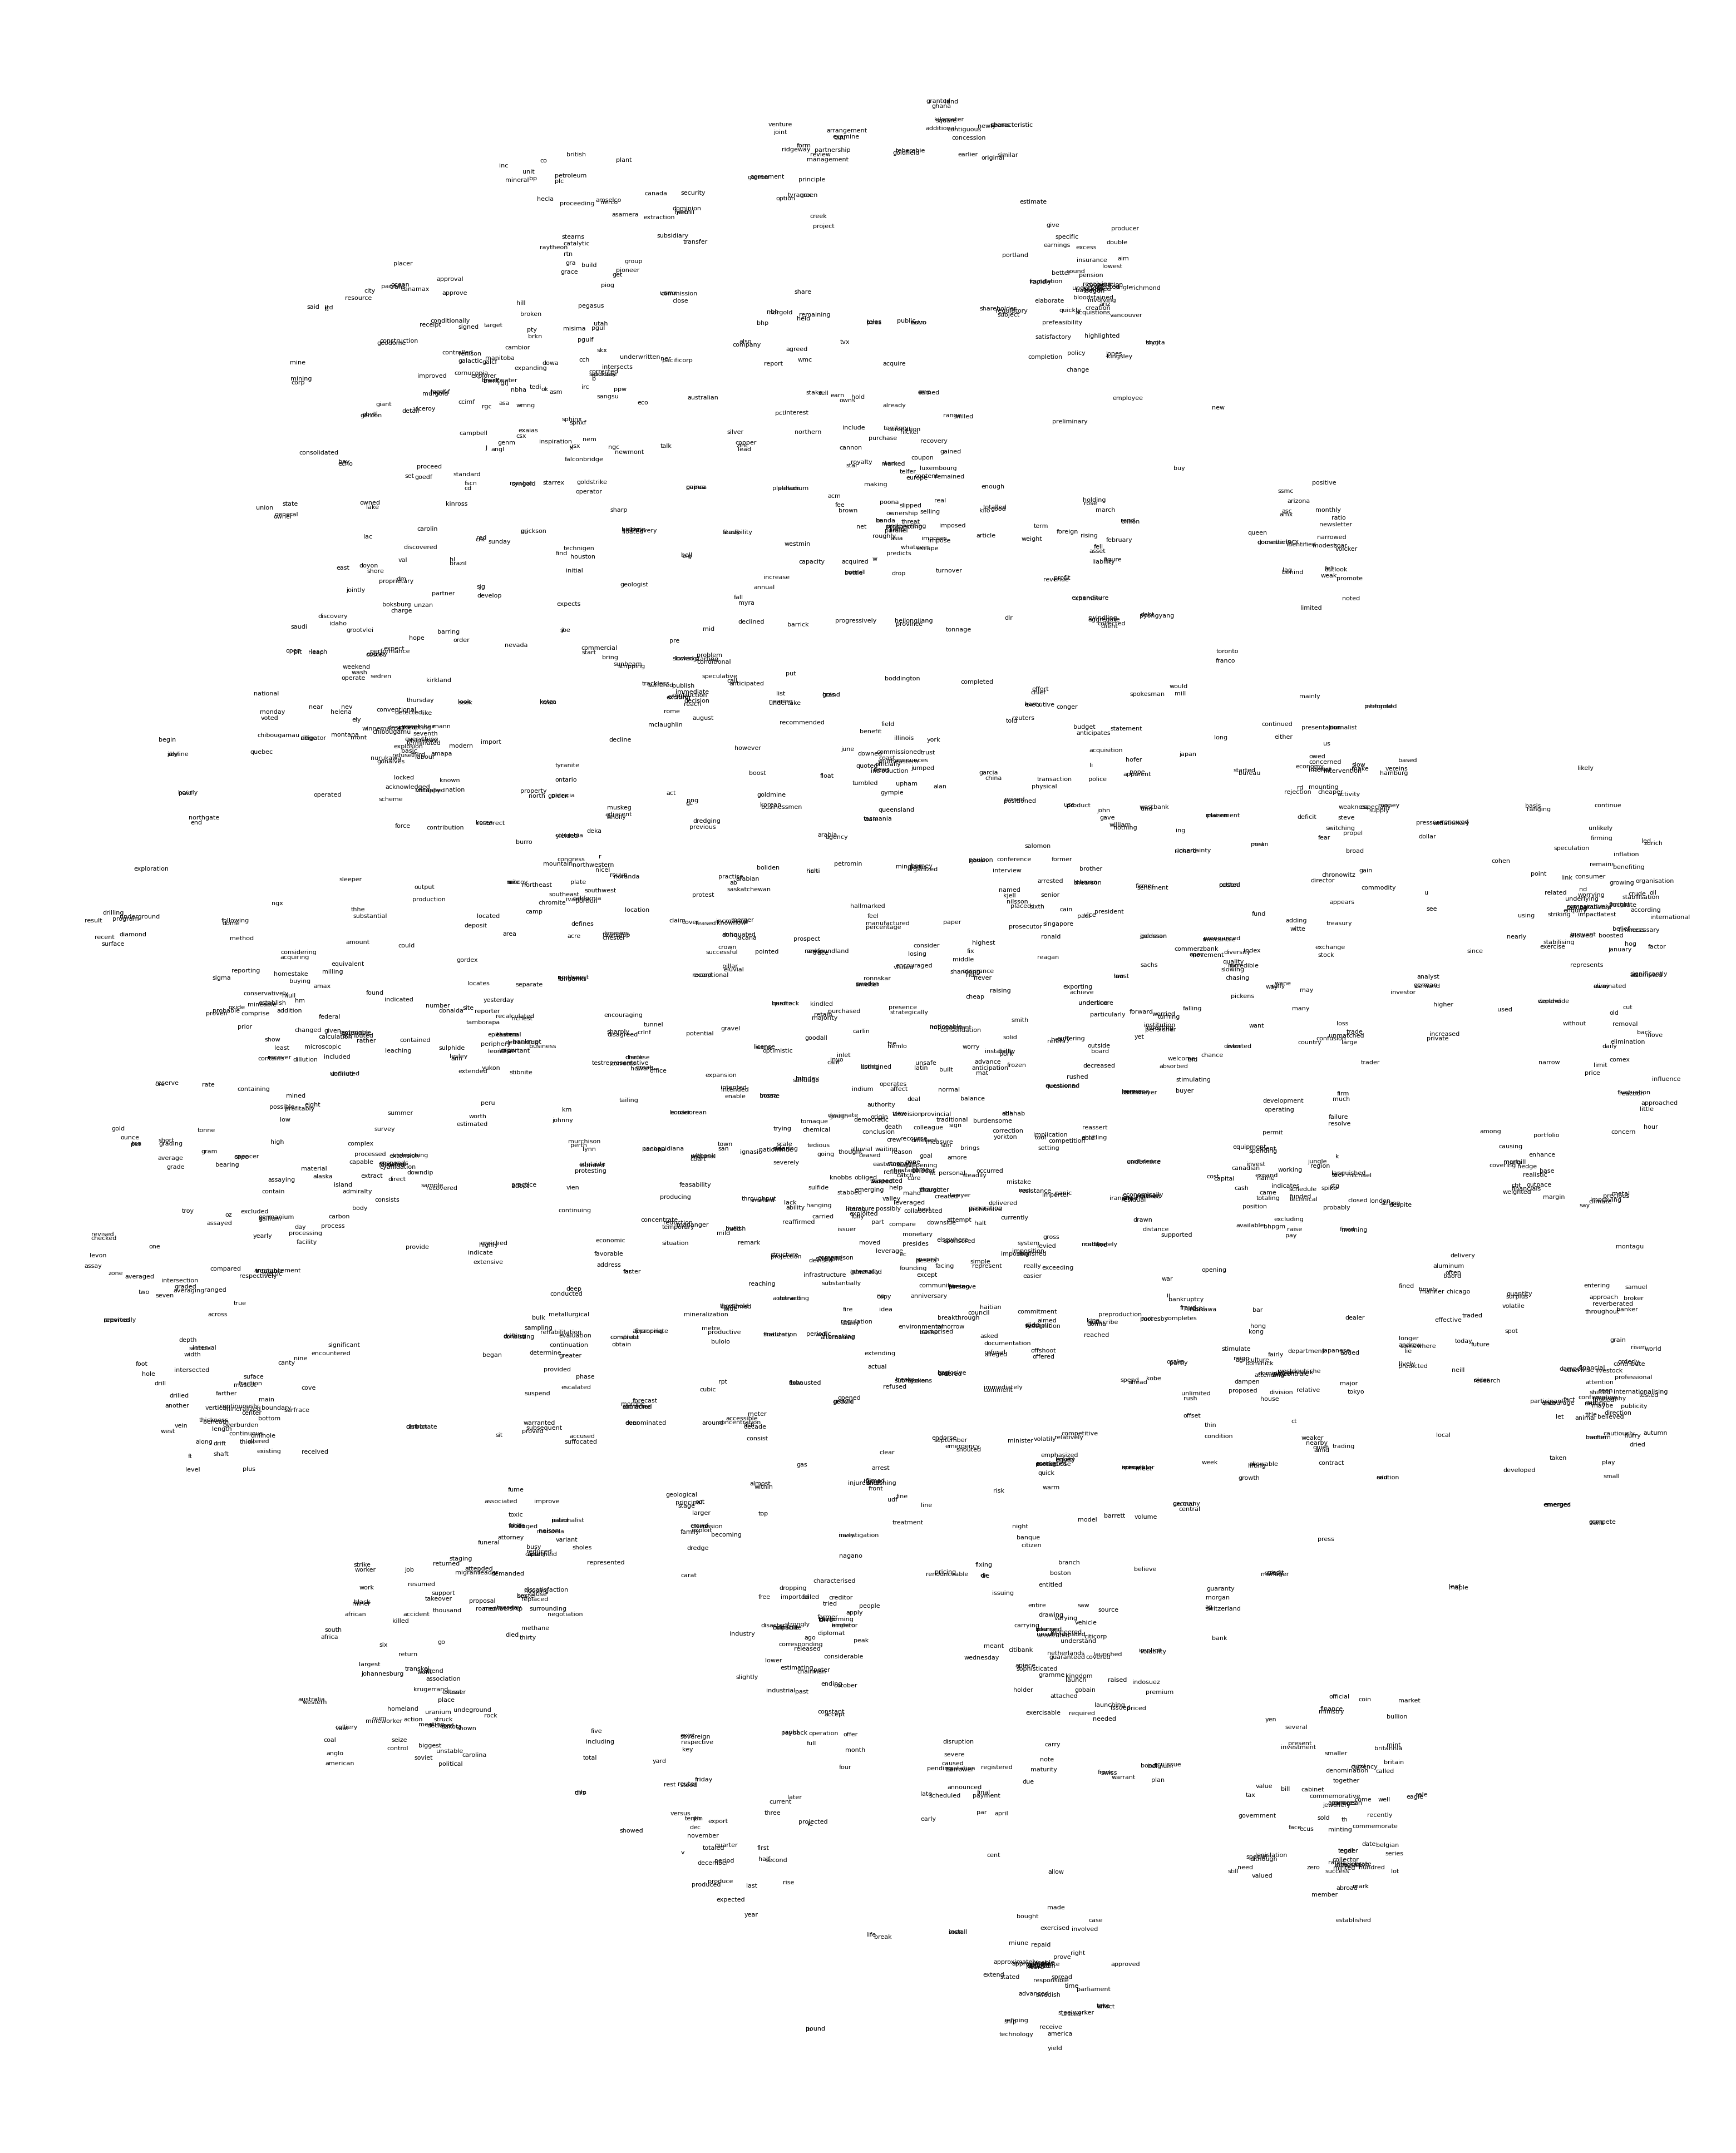

In [ ]:
tsne_viz(matrix_lsa, word_index, colors=None, output_filename=None, figsize=(40, 50), random_state=None)

## Part 3: Application to sentiment analysis

In this last part we will apply pre-computed word representation to perform **sentiment analysis**. We will use [Stanford Sentiment Treebank (SST)](http://nlp.stanford.edu/sentiment/), a widely-used dataset for evaluating supervised NLP models. This dataset contains sentences annotated with three different labels according to the sentiment they convey: positive, negative or neutral. 

Here you have some examples of sentences with their labels that you can find in the dataset:

`[{'example_id': '04162-00001',
  'sentence': "One can only assume that the jury who bestowed star Hoffman 's brother Gordy with the Waldo Salt Screenwriting award at 2002 's Sundance Festival were honoring an attempt to do something different over actually pulling it off",
  'label': 'negative',
  'is_subtree': 0},
 {'example_id': '05626-00001',
  'sentence': "Comedy troupe Broken Lizard 's first movie is very funny but too concerned with giving us a plot .",
  'label': 'neutral',
  'is_subtree': 0},
 {'example_id': '02940-00001',
  'sentence': "Imagine O. Henry 's The Gift of the Magi relocated to the scuzzy underbelly of NYC 's drug scene .",
  'label': 'negative',
  'is_subtree': 0}]`
  
  If you want to have a look to some sample sentences of the dataset you can run the following script:

In [ ]:
DATA_HOME = 'data'
SST_HOME = os.path.join(DATA_HOME, 'sentiment')
train_df = sst.train_reader(SST_HOME)
train_df.sample(3).to_dict(orient="records")

[{'example_id': '04817-00001',
  'sentence': "We never truly come to care about the main characters and whether or not they 'll wind up together , and Michele 's spiritual quest is neither amusing nor dramatic enough to sustain interest .",
  'label': 'negative',
  'is_subtree': 0},
 {'example_id': '00723-00001',
  'sentence': 'A subtle , humorous , illuminating study of politics , power and social mobility .',
  'label': 'positive',
  'is_subtree': 0},
 {'example_id': '03122-00001',
  'sentence': 'A must for fans of British cinema , if only because so many titans of the industry are along for the ride .',
  'label': 'positive',
  'is_subtree': 0}]

For this exercise we will use an already **pre-computed co-occurrence matrix**. We will also provide a script that runs a complete **classification experiment** on the sentiment dataset: loading the dataset (train and test), computing features on all the documents, training a classifier and testing the classifier computing evaluation metrics. 

You will have to **implement** the function **`vsm_features`** that returns the feature representation of a text string. This function takes as input the text string and the matrix with of word representations and must get a single representation of the text string by computing the representation of all the words in the text string and aggegating them using some aggregation function (`sum`, `mean`, ...).

The process of classification of a text string is illustrated in the following figure:

<img src="fig/distreps-as-features.png" width=500 alt="distreps-as-features.png" />

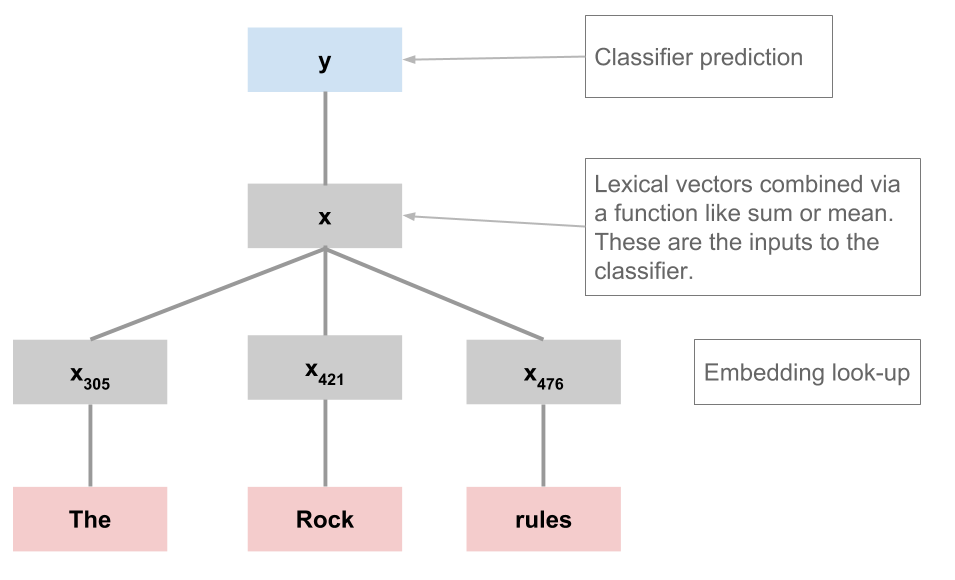

### Computing features and training a classifier

In the next cell you have all the functions that are necessary to run the classification experiment on the sentiment dataset. 

We already provide the function **`fit_softmax_classifier`** that **trains a classifier** given a feature representation of the training set and the set of labels. This function uses `LogisticRegression` as a classifier, but any classifier could be used. You can try with different classification functions if you want.

Here, you have to **implement** the function **`vsm_features`** that get the aggregated representation of an input text string as explained before. The `vsm` parameter is a tuple that contains the vector space model, the matrix with the representation of all the words in the vocabulary and a dictionary with the mapping of all words to indices of the matrix. This function must compute the representation of all the words in the text string and aggregate them using the aggregation function specified in `aggr_func`.

In [ ]:
import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize as tokenize

import numpy as np

def fit_softmax_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='auto')
    mod.fit(X, y)
    return mod

def compute_features(text, aggr_func=np.sum):
    return vsm_features(text, vsm, aggr_func)

def vsm_features(text, vsm, aggr_func=np.sum):
    """Represent `text` as a combination of the vector of its words.

    Parameters
    ----------
    text : str 

    vsm : tuple where the first element is a co-occurrence matrix and the second element is the dictionary that maps words to indices in the matrix

    aggr_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a
        fixed length, no matter what the size of the text is.

    Returns
    -------
    features: np.array, dimension `X.shape[1]`

    """
    
    ### BEGIN SOLUTION
    tokens = tokenize(text)
    indices = []
    for token in tokens:
        if token in vsm[1]:
            indices.append(vsm[1][token])
    vectors = vsm[0][indices]
    features = aggr_func(vectors, axis=0)
    
    ### BEGIN SOLUTION
    return features

### Creating the Vector Space Model

In the next cell you have all the code to load pre-computed co-occurrence matrix and get the final vector space model that will be used for computing text features and perform the taks of sentiment classification. 

First, we load the pre-computed `yelp20` matrix, convert it to a `numpy` array and create the dictionary mapping words to indices. Then, we normalize the matrix with PPMI and apply LSA to reduce dimensionality. Finally we create the final Vector Space Model that is needed for the function `vsm_features` as the tuple with the matrix and the dictionary.

In [ ]:
DATA_HOME = 'data'
VSMDATA_HOME = os.path.join(DATA_HOME, 'vsmdata')
SST_HOME = os.path.join(DATA_HOME, 'sentiment')

# Read pre-computed co-occurrence matrix
yelp20 = pd.read_csv(os.path.join(VSMDATA_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)

# Convert co-occurrence matrix to numpy and create dictionary to map words to indices in the matrix
matrix = yelp20.to_numpy()
word_index = dict(zip(yelp20.index, range(len(yelp20.index))))

# Compute ppmi and lsa from original co-occurrence matrix
matrix_ppmi = compute_ppmi(matrix)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=300)

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...


In [ ]:
vsm[0].shape

(6000, 300)

### Evaluation of the model

In the next cell you have the script to perform the classification experiment in the sentiment dataset. It loads the sentiment dataset, train a classifier using the function `fit_softmax_classifier` and the features computed using `vsm_features` and evaluates the classifier on the dev set of the sentiment dataset, reporting evaluation metrics.

**Run this script** using your implementation of `vsm_features`. You can **try different configurations** of your vector space model and compare the results:  with and without PPMI normalization, different dimensionality of the embedding space after LSA, different values for the smoothing in PPMI , ...

In [ ]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

# This code runs the experiment on the sentiment analysis dataset using `compute_features` to get a feature representation of a text string 
# and `fit_softmax classifier` as a classification function


              precision    recall  f1-score   support

    negative      0.565     0.673     0.614       428
     neutral      0.344     0.048     0.084       229
    positive      0.580     0.730     0.646       444

    accuracy                          0.566      1101
   macro avg      0.496     0.484     0.448      1101
weighted avg      0.525     0.566     0.517      1101

CPU times: user 6.81 s, sys: 33.3 ms, total: 6.84 s
Wall time: 6.83 s


Trying another vector space model (K = 100)

In [ ]:
DATA_HOME = 'data'
VSMDATA_HOME = os.path.join(DATA_HOME, 'vsmdata')
SST_HOME = os.path.join(DATA_HOME, 'sentiment')

# Read pre-computed co-occurrence matrix
yelp20 = pd.read_csv(os.path.join(VSMDATA_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)

# Convert co-occurrence matrix to numpy and create dictionary to map words to indices in the matrix
matrix = yelp20.to_numpy()
word_index = dict(zip(yelp20.index, range(len(yelp20.index))))

# Compute ppmi and lsa from original co-occurrence matrix
matrix_ppmi = compute_ppmi(matrix)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=100) #CHANGED VALUE, FROM 300 TO 100

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...


In [ ]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

# This code runs the experiment on the sentiment analysis dataset using `compute_features` to get a feature representation of a text string 
# and `fit_softmax classifier` as a classification function


              precision    recall  f1-score   support

    negative      0.564     0.682     0.617       428
     neutral      0.750     0.013     0.026       229
    positive      0.568     0.741     0.643       444

    accuracy                          0.567      1101
   macro avg      0.627     0.479     0.429      1101
weighted avg      0.604     0.567     0.505      1101

CPU times: user 2.86 s, sys: 90.7 ms, total: 2.95 s
Wall time: 2.9 s


It seems a bit better

Trying another vector space model (add_k_smoothing = 5)

In [ ]:
DATA_HOME = 'data'
VSMDATA_HOME = os.path.join(DATA_HOME, 'vsmdata')
SST_HOME = os.path.join(DATA_HOME, 'sentiment')

# Read pre-computed co-occurrence matrix
yelp20 = pd.read_csv(os.path.join(VSMDATA_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)

# Convert co-occurrence matrix to numpy and create dictionary to map words to indices in the matrix
matrix = yelp20.to_numpy()
word_index = dict(zip(yelp20.index, range(len(yelp20.index))))

# Compute ppmi and lsa from original co-occurrence matrix
matrix_ppmi = compute_ppmi(matrix, add_k_smoothing=5)#CHANGED add_k_smoothing VALUE, FROM 300 TO 100
matrix_ppmi_lsa = lsa(matrix_ppmi, k=300) 

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...


In [ ]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

# This code runs the experiment on the sentiment analysis dataset using `compute_features` to get a feature representation of a text string 
# and `fit_softmax classifier` as a classification function


              precision    recall  f1-score   support

    negative      0.553     0.650     0.597       428
     neutral      0.286     0.044     0.076       229
    positive      0.574     0.727     0.642       444

    accuracy                          0.555      1101
   macro avg      0.471     0.474     0.438      1101
weighted avg      0.506     0.555     0.507      1101

CPU times: user 6.55 s, sys: 122 ms, total: 6.68 s
Wall time: 6.54 s


It seems a bit worse